In [12]:
'''
Synthetic dataset to be able to hide one ground truth to discover it

Trajectory generation between two points is taken from the code from the paper:
Diverse Trajectory Forecasting with Determinantal Point Processes
Ye Yuan, Kris Kitani

from the paper:
- simulated vehicle behavior
- add Gaussian noise to vehicle velocities
- each data example (past, future) as 3 future steps and 2 past steps
- Add an obstacle map around the current position to the context
- total of 1100 training examples and 1000 test examples
- road width is 2
'''

import errno
import numpy as np
import os
import torch
import yaml

from collections import defaultdict

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches

from PIL import Image

from scipy import ndimage


## elements

In [2]:


class Trajectory:

    def __init__(self, points, layout_name, path_name):
        self.points = np.array(points)
        self.layout = layout_name
        self.pathname = path_name

    def render(self, ax, clip=False):
        x_values = list()
        y_values = list()
        pixel_pts = meters_to_pixels_traj(self.points, clip=clip)
        
        for p in pixel_pts:

            x_values.append(p[0])
            y_values.append(p[1])

        ax.plot(x_values, y_values, lw=1, c='r', zorder=5)


In [4]:


class Segment:
    def __init__(self, spec):
        self.sp = np.array(spec['sp'])
        self.ep = np.array(spec['ep'])
        self.ttraj = spec['ttraj']
        self.mp = spec['mp']
        self.theta = spec.get('theta')
        self.inv = spec.get('inv')

        self.pts = gen_points(self.sp, self.ep, self.ttraj, self.mp, self.theta, self.inv)

        self.e_t = self.pts[-1] - self.pts[-2]
        self.e_t = self.e_t / np.linalg.norm(self.e_t)
        self.e_n = np.array([-self.e_t[1], self.e_t[0]])




In [5]:
class Layout:

    def __init__(self, config):
        self.name = config['name']
        self.polygons = np.array(config['polygons'])

    def render(self, ax):
        pc = list()
        for p in self.polygons:
            polygon = Polygon(p, True, facecolor=[0.2, 0.2, 0.2])
            pc.append(polygon)

        all_patches = PatchCollection(pc)
        ax.add_collection(all_patches)


In [3]:
class Path:
    '''
    ground truth
    '''

    def __init__(self, path_cfg):
        self.layout = path_cfg['layout']
        self.orientation = path_cfg['orientation']
        self.speed = path_cfg['speed']
        self.sp = np.array(path_cfg['sp'])

        segs = list()
        pts = list([self.sp])
        for sspec in path_cfg['segments']:
            seg = Segment(sspec)
            pts.extend(seg.pts[1:])
            segs.append(seg)

        self.points = np.vstack(pts)
        self.segments = segs
        print("created paths in %s segments" % len(self.segments))

    def render(self, ax, clip=False):

        print(f"rendering path with points {self.points}")
        x_values = list()
        y_values = list()

        pixel_pts = meters_to_pixels_traj(self.points, clip=clip)

        for p in pixel_pts:
            x_values.append(p[0])
            y_values.append(p[1])

        print(f"plotting the path with x {x_values} and y {y_values} points")

        ax.plot(x_values, y_values, lw=1, c='g', zorder=5)


## helper functions

In [6]:


def gen_points(sp, ep, ttraj, mp, theta=None, inv=None):
    '''
    generate intermediate points between start point sp and end point ep
    line or arc depending on relation between sp and ep
    function taken mostly from Yuan & Kitani

    sp: start point
    ep: end point
    ttraj: type of trajectory (line or arc)
    mp: number of intermediate points
    theta: angle for arcs
    inv: inversion for arcs
    '''
    pts = [sp.copy()]

    # line between points (ez)
    if ttraj == 'line':
        d = (ep - sp) / (mp + 1)
        for i in range(mp):
            p = sp + d * (i + 1)
            pts.append(p)

    # arc between points
    elif ttraj == 'arc':
        theta = np.deg2rad(60)
        a = (ep + sp) / 2
        d = ep - sp
        dist = np.linalg.norm(d)
        d /= dist
        e = np.array([-d[1], d[0]]) * (-1 if inv else 1)
        c = a + e * (0.5 * dist / np.tan(theta / 2))
        r = 0.5 * dist / np.sin(theta / 2)
        t1 = np.arctan2(sp[1] - c[1], sp[0] - c[0])
        t2 = np.arctan2(ep[1] - c[1], ep[0] - c[0])
        dt = (t2 - t1) / (mp + 1)
        for i in range(mp):
            t = t1 + dt * (i + 1)
            p = np.array([c[0] + r * np.cos(t), c[1] + r * np.sin(t)])
            pts.append(p)

    pts.append(ep.copy())
    return pts


def meters_to_pixels_traj(traj, clip=False):
    '''
    converts a matrix of points in relative meters (in the 14m x 14m grid centered on the vehicle with 4m behind, 10m forward and 7m each side) 
    to a point in pixels in a 224x224 grid with (0, 0) in the top left corner

    TODO: make this function common to all datasets and manage the clip and the transformation matrix with the right dataset parameters instead of hardcoding
    '''
    shape = traj.shape
    nostack = False
    if len(shape) == 2:
        nb_pts, dim = shape
        all_traj = np.expand_dims(traj, 0)
        nostack = True
        nb_traj = 1
    elif len(shape) == 3:
        nb_traj, nb_pts, dim = traj.shape
        all_traj = traj.copy()
    else:
        raise Exception(f"unknown traj shape {shape}")
        
    assert all_traj.shape == (nb_traj, nb_pts, dim)
    
    pixel_trajs = list()
    for t in all_traj:
        assert t.shape == (nb_pts, dim)
        traj_2 = np.append(t, np.ones((nb_pts, 1)), axis=1)
    
        assert traj_2.shape == (nb_pts, 3)

        hmatrix = np.array([[16, 0, 64], [0, 16, 112], [0, 0, 1]])
        pixel_traj = np.matmul(hmatrix, np.transpose(traj_2))
        pixel_traj = np.transpose(pixel_traj)
        pixel_trajs.append(pixel_traj[:, 0:2])
    
    result = np.stack(pixel_trajs, 0)
    if nostack:
        result = result[0]

    if clip:
        result = np.clip(result, 0, 223)

    return result


def da_rendering(da, traj):
    '''
    renders a trajectory (as a collection of x,y points) on top of an image
    both the image and the trajectory are from a top-left origin point
    the trajectory should be in the pixel space (call meters_to_pixels_traj before if needed)
    '''
    fig = plt.figure(figsize=(2.24, 2.24), dpi=100)
    ax = fig.add_subplot(111)

    ax.imshow(da)
    
    traj_x = list()
    traj_y = list()
    for pt in traj:
        traj_x.append(pt[0])
        traj_y.append(pt[1])

    ax.scatter(traj_x, traj_y, lw=1, c='r')
    
    plt.show()




## Actual dataset

In [7]:

class SynTrajDataset(Dataset):
    '''
    Synthetic trajectories dataset
    - represents crossroads with several future possible trajectories
    - one modality is systematically omitted (e.g. trajectories going left)
    '''

    def __init__(self, config_path, split, omit=None):
        '''
        omit: the direction of the omitted direction in train
        '''
        assert split in ['train', 'test']
        if split == 'train':
            assert omit in ['left', 'right', 'straight']
        else:
            assert omit is None

        if not os.path.isfile(config_path) and not config_path.startswith('/'):
            alt_config_path = '../dataset/' + config_path
            print(alt_config_path)

            if os.path.isfile(alt_config_path):
                config_path = alt_config_path
            else:
                raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), config_path)

        # transformation matrix to go from trajectories in meters relative to the (O, O) to trajectories in pixel where (0, 0) is the top-left corner
        self.trans_matrix = np.array([[16, 0, 64], [0, 16, 112], [0, 0, 1]])

        self.layouts = {}    # name of the layout -> Layout object
        self.paths = []
        self.paths_per_layout = defaultdict(lambda: list())
        self.config = yaml.safe_load(open(config_path, 'r'))
        self.past_size = self.config['trajectory']['past_size']
        self.future_size = self.config['trajectory']['future_size']
        self.folder_path = os.path.sep.join(config_path.split(os.path.sep)[:-1])
        print(f'considering folder path {self.folder_path}')

        for layout in self.config['layouts']:
            self.layouts[layout['name']] = Layout(layout)
        for path in self.config['paths']:
            p = Path(path)
            self.paths.append(p)
            self.paths_per_layout[p.layout].append(p.points)

        # constraint on path depending on omit parameter
        if split == 'train':
            probs = np.array([(0.0 if p.orientation == omit else 1.0) for p in self.paths])
        else:
            probs = np.ones(len(self.paths))
        self.pprobs = probs
        # print(f"probs {probs}")

        # layouts
        self.size = np.array(self.config['pixel_size'])
        self.layout_to_index = {name: i for i, name in enumerate(self.layouts.keys())}
        self.nb_layouts = len(self.layouts)
        self.layout_renders, self.drivable_areas, self.diffmaps, self.gradients = self.render_layouts()

        self.trajs = self.gen_traj(int(self.config['trajectory']['n_train']), float(self.config['trajectory']['noise_n']))

        # random order
        rng = np.random.default_rng()
        self.ex_order = np.arange(len(self.trajs))
        rng.shuffle(self.ex_order)

        self.preprocess = transforms.ToTensor()

    def gen_traj(self, num, noise_n, balance=False):
        trajs = []

        # num = number of trajectories total
        for i in range(num):
            # pick a path
            path = np.random.choice(self.paths, p=self.pprobs / self.pprobs.sum())

            # print('picked path %s in %s' % (path.orientation, path.layout))
            sp = path.points[0].copy()                  # start point of segment
            sp[1] += noise_n * np.random.randn(1)       # add noise on start point
            traj_pts = [sp]
            # print("noised sp %s" % str(sp))

            # build trajectory by interpolating between noised waypoints of selected path
            for seg in path.segments:

                ep = seg.ep.copy()    # end point of segment
                # print("ep %s" % str(ep))

                # add noise to end point
                noise = np.clip(np.random.randn(2), -1.5, 1.5)
                ep += seg.e_n * noise[1] * noise_n * 2.8    # noise scaling was 5.6 with previous 28x28 coordinates, now the coords are 14x14 meters so now it's 2.8
                # print("noised ep %s" % str(ep))

                # generate points between start and end point
                gen_pts = gen_points(sp, ep, seg.ttraj, seg.mp, seg.theta, seg.inv)

                # add generated points to trajectory
                traj_pts.extend(gen_pts[1:])

                # print('new path points %s' % str(traj_pts))

                sp = ep

            # add traj to list
            trajs.append(Trajectory(traj_pts, path.layout, path.orientation))

        return trajs

    def render(self, axs, draw_path=False, draw_traj=False, clip=True):
        '''
        rendering for viz only - all layouts are put on a single image
        draw_path: do we draw each GT trajectory on the layouts
        draw_traj: do we also draw all generated trajectories
        '''

        for i, (name, layout) in enumerate(self.layout_renders.items()):
            axs[i].set_title(name)
            # axs[i].axis([0, 224, 0, 224])
            axs[i].imshow(layout, origin='upper')

        if draw_path:
            for path in self.paths:
                index = self.layout_to_index[path.layout]
                path.render(axs[index], clip=clip)
        if draw_traj:
            for traj in self.trajs:
                index = self.layout_to_index[traj.layout]
                traj.render(axs[index], clip=clip)

    def render_layouts(self):
        '''
        get image of one layout
        '''
        layout_renders = dict()
        drivable_areas = dict()
        gradients = dict()
        diffmaps = dict()

        ax_range = self.config['range']

        for name, layout in self.layouts.items():
            figsize = self.size[:-1] / 100
            fig = plt.figure(figsize=figsize, dpi=100)    # making a square figure so that the canvas is also square
            ax = fig.add_subplot(111)
            
            rect = patches.Rectangle((ax_range[0], ax_range[2]), ax_range[1] - ax_range[0], ax_range[3] - ax_range[2],
                                 facecolor=[0.9, 0.9, 0.9], zorder=0)
            ax.set_aspect(1.0)
            # ax.axis(ax_range)
            ax.add_patch(rect)
            ax.set_facecolor([0.9, 0.9, 0.9])

            layout.render(ax)
            
            ax.axis('off')
            fig.tight_layout(pad=0)
            ax.margins(0)     # To remove the huge white borders

            fig.canvas.draw()
            image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
            image_from_plot = image_from_plot.reshape(self.size)

            layout_renders[name] = image_from_plot

            # Binary DA map from layout
            layout_image = image_from_plot.copy()
            binary_layout = layout_image[:,:,0]
            binary_layout[binary_layout != 230] = 255  # from blue (not road) and white (road) to 0 (road) and 1 (not road)
            binary_layout[binary_layout == 230] = 0
            drivable_areas[name] = binary_layout

            # Diff map
            diff_path = os.path.join(self.folder_path, f'diff_layout_{name}.png')
            diffmap = ndimage.distance_transform_edt(binary_layout)
            if not os.path.exists(diff_path):
                diff_im = Image.fromarray(diffmap)
                diff_im = diff_im.convert("L")
                diff_im.save(diff_path)

            # gradients (we load again because taking diffmap directly doesn't work for some reason)
            imgdiff = Image.open(diff_path)
            npimg = np.asarray(imgdiff)
            diffmaps[name] = npimg
            g2 = np.gradient(npimg, edge_order=2)

            gx2 = g2[0]
            gy2 = g2[1]

            gradients[name] = (gx2, gy2)

        return layout_renders, drivable_areas, diffmaps, gradients

    def render_example(self, axs, sample, clip=True):
        '''
        renders a specific example, not using the internals of the dataset rendering
        this is mostly to check what the samples we generate look like from an external point of view (i.e. what the model will see)

        example of use:
        fig, axs = plt.subplots(1,5)
        example = dataset_train[5]
        dataset_train.render_example(axs, example)
        plt.show()
        '''
        # first ax: layout + past and future trajectories
        axs[0].imshow(sample['image'].permute(1, 2, 0))

        past_x = list()
        past_y = list()
        future_x = list()
        future_y = list()

        past_pixels = meters_to_pixels_traj(sample['past_xy'], clip=clip)
        future_pixels = meters_to_pixels_traj(sample['future_xy'], clip=clip)

        for pp in past_pixels:
            print(f'past traj point {pp[0]}')
            past_x.append(pp[0])
            past_y.append(pp[1])

        axs[0].plot(past_x, past_y, lw=1, c='r')

        for fp in future_pixels:
            print(f'future traj point {fp}')
            future_x.append(fp[0])
            future_y.append(fp[1])

        axs[0].plot(future_x, future_y, lw=1, c='g')

        # da mask and diff map
        axs[1].imshow(sample['da_mask'])
        axs[2].imshow(sample['d_mask'])

        # x and y gradients
        axs[3].imshow(sample['dx_mask'])
        axs[4].imshow(sample['dy_mask'])

    def __len__(self):
        return len(self.trajs)

    def __getitem__(self, idx):
        '''
        only one int idx at a time
        '''
        traj = self.trajs[self.ex_order[idx]]

        # past and future trajectories
        past = np.array(traj.points[:self.past_size])
        future = np.array(traj.points[self.past_size:])
        info = {'path_orientation': traj.pathname, 'layout': traj.layout}

        assert past.shape == (self.past_size, 2), 'got shape %s' % str(past.shape)
        assert future.shape == (self.future_size, 2), 'got shape %s' % str(future.shape)

        # layout map
        layout_np = self.layout_renders[traj.layout]
        input_tensor = self.preprocess(layout_np)
        assert input_tensor.shape == (3, 224, 224), 'expected (3, 224, 224), got %s' % str(input_tensor.shape)

        # diff and gradient maps and DA
        npdiff = self.diffmaps[traj.layout]
        npdt = torch.Tensor(npdiff)
        npdx = self.gradients[traj.layout][0]
        npdxt = torch.Tensor(npdx)
        npdy = self.gradients[traj.layout][1]
        npdyt = torch.Tensor(npdy)

        da = torch.Tensor(self.drivable_areas[traj.layout])

        sample = {'past_xy': past, 'future_xy': future, 'image': input_tensor, 'd_mask': npdt, 'dx_mask': npdxt, 'dy_mask': npdyt, 'da_mask': da, 'info': info}
        # 'gt_paths': np.array(self.paths_per_layout[traj.layout])

        return sample


## Test

In [20]:
config_path = 'synthetic_relative.yml'

considering folder path /share/homes/lcalem/LSD/dataset
created paths in 3 segments
created paths in 2 segments
created paths in 3 segments
created paths in 3 segments
created paths in 3 segments


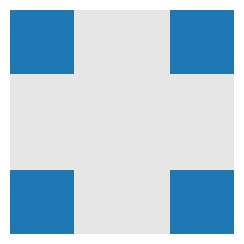

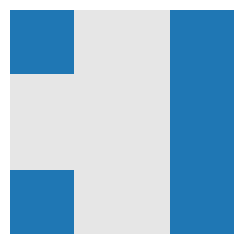

In [16]:
dataset_test = SynTrajDataset(config_path=config_path, split='test')
# dataset_test = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=0)

{'path_orientation': 'right', 'layout': 't-shaped'}
past traj point 0.0
past traj point 17.6
past traj point 35.2
past traj point 52.800000000000004
future traj point [ 70.4        110.53366306]
future traj point [ 96.59662868 117.89482766]
future traj point [119.99541929 131.78535309]
future traj point [139.00178292 151.25862298]
future traj point [152.32046729 174.98756617]
future traj point [153.66849817 191.25144554]
future traj point [155.01652906 207.51532491]
future traj point [156.36455994 223.        ]


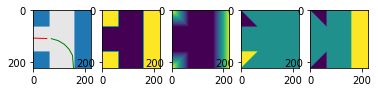

In [19]:
fig, axs = plt.subplots(1,5)
example = dataset_test[5]
print(example['info'])
dataset_test.render_example(axs, example)
plt.show()